# Deep Learning and Neural Networks
## Time Prediction

In [ ]:
import keras
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, Flatten, Dense, Activation, MaxPooling2D, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import os
import pprint
import tensorflow as tf
from keras.models import Sequential
import keras.backend as K
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import math_ops
from keras.regularizers import l2

inp = Input(shape=(150,150, 1)) # saving the size of image
x = Conv2D(50, kernel_size=5, strides=2, kernel_regularizer=l2(0.01),activation='relu')(inp)#regularizer l2 is used as the features are corelated
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = Conv2D(100, kernel_size=3, strides=1, activation='relu')(x)#increasing number of filters for extracting more features out of image
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(150, kernel_size=3, strides=1,kernel_regularizer=l2(0.01), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(200, kernel_size=3, strides=1,kernel_regularizer=l2(0.01), activation='relu')(x)
x = Dropout(.4)(x)# dropout layer applied after convolution and maxpooling layers to avoid overfitting
x = Flatten()(x)
hour = Dense(150, activation='relu')(x) #hour is treated as classification task hence combination of relu and softmax is used 
hour = Dense(12, activation='softmax', name='hour')(hour)
minute = Dense(150, activation='relu')(x) #passing the x parameter here allows us to seprate the two outputs in the model 
minute = Dense(1, activation='linear', name='minute')(minute)# as minute is treated as regression task final layer is narrowed down to 1
model = Model(inputs=inp, outputs=[hour, minute]) # defining the input shape and extracting two outputs from the model.
model.summary()
X = np.load('/content/drive/My Drive/images.npy')#loading the image features
y = np.load('/content/drive/My Drive/labels.npy')#loading the labels
x_train, x_validation, y_train, y_validation = train_test_split(  X, y, test_size=0.3, random_state=42) # basic split of trian and test 
x_train = x_train.reshape(x_train.shape[0], 150, 150, 1) #as we have used convolutional layer we need to reshape the input 
x_validation = x_validation.reshape(x_validation.shape[0], 150, 150, 1) #input is reshaped into total number , size of each image, no. of channels


y1_train = y_train[:,0] # hour labels passed as it is
y2_train = y_train[:,1]/5 # minute labels passed by dividing them by 5
y1_test = y_validation[:,0] # hour labels passed as it is
y2_test = y_validation[:,1]/5 # minute labels passed by dividing them by 5


#following is the custom error calculation function in which we first take the labels and if the difference between them is more than 6 we add
# 12 in the small number from the tuple y_true and y_pred this allows us to find the acutal difference in the timings as we have divided the minutes
# by 5 above we can use same function to calculate error in minutes as well


def hand_error(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    
    diff =  tf.where((K.maximum(y_pred , y_true)-K.minimum(y_pred , y_true))> 6 ,K.minimum(y_true,y_pred)+12 - K.maximum(y_pred,y_true),(K.maximum(y_pred , y_true)-K.minimum(y_pred , y_true))-1)
    return K.mean(math_ops.abs(diff))


#compiling the model with custom function along with the accuracy.
model.compile(loss=['sparse_categorical_crossentropy', 'mse'], optimizer='adam', metrics=['accuracy',hand_error])
history = model.fit(x_train, [y1_train, y2_train], epochs=150, batch_size=256, validation_data=(x_validation, [y1_test, y2_test]))


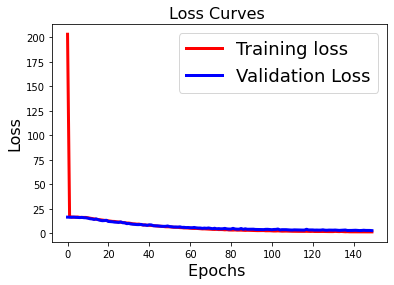

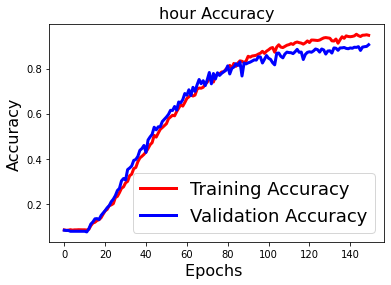

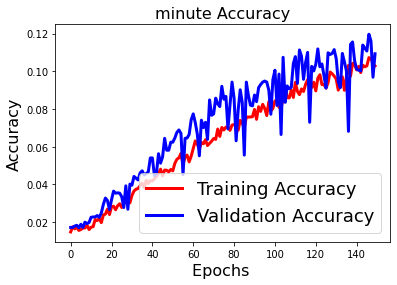

In [0]:
#plots for the loss and accuracies
#here we can check how loss was decreasing with the begining of the epochs 
#accuracy in case of minutes is low due to the fact that it is solved as the regression problem 


import matplotlib.pyplot as plt
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves ',fontsize=16)
fig1.savefig('loss.png')
plt.show()

fig2=plt.figure()
plt.plot(history.history['hour_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_hour_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('hour Accuracy',fontsize=16)
fig2.savefig('hour_accuracy.png')
plt.show()

fig3=plt.figure()
plt.plot(history.history['minute_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_minute_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('minute Accuracy',fontsize=16)
fig2.savefig('minute_accuracy.png')
plt.show()


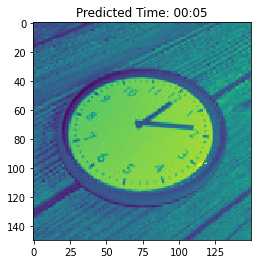

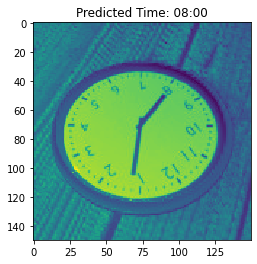

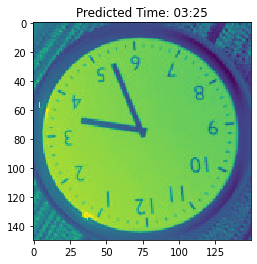

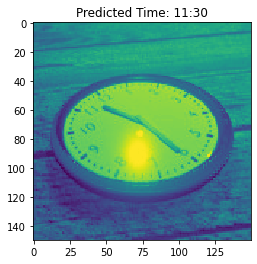

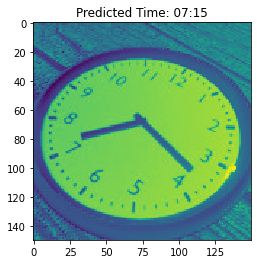

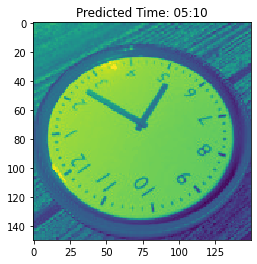

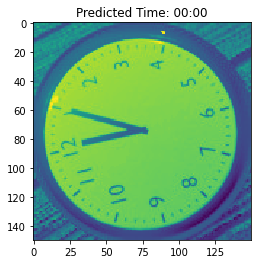

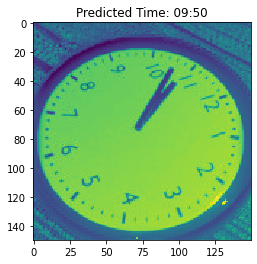

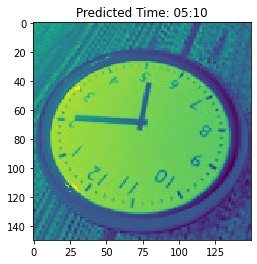

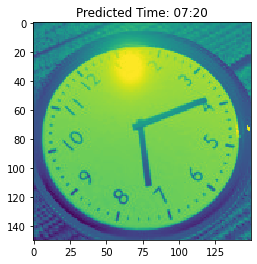

In [0]:
#we saw the statistics above for the loss and accuracy 
#lets check how the model is actually performing and how close it is guessing the time 


from datetime import datetime as timeconv
np.random.seed(1)
rnums  = np.random.randint(low=0, high=X.shape[0], size=10)
for num in rnums:
  time = model.predict(X[num].reshape(1, 150, 150, 1))
  hour = np.argmax(time[0])
  minute = int(time[1])*5
  x =  timeconv(2020, 4, 20, hour, minute)
  title = 'Predicted Time: '+ x.strftime("%H:%M")
  fig = plt.figure()
  plt.imshow(X[num], interpolation='nearest')
  plt.title(title)
  fig.savefig('predictedtime'+str(num)+'.png')
  plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive/DLNN')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
